# Data preparation #1

Useful resources:

* Used dataset:
    * [NIH Clinical Center provides one of the largest publicly available chest x-ray datasets to scientific community](https://www.nih.gov/news-events/news-releases/nih-clinical-center-provides-one-largest-publicly-available-chest-x-ray-datasets-scientific-community)
    * [NIH CC ChestXRay Dataset (box.com)](https://nihcc.app.box.com/v/ChestXray-NIHCC)
    * [NIH CC ChestXRay Dataset (Google Cloud)](https://cloud.google.com/healthcare/docs/resources/public-datasets/nih-chest)
* Datasets:
    * [Google Dataset Search](https://datasetsearch.research.google.com/)
    * [Awesome Public Datsets on GitHub](https://github.com/awesomedata/awesome-public-datasets)
* Pandas:
    * [10 minutes to Pandas tutorial](https://pandas.pydata.org/pandas-docs/stable/user_guide/10min.html)

## Imports

In [1]:
import os
import urllib.request
from multiprocessing import Pool, cpu_count

import pandas as pd
import tqdm
from PIL import Image

## Constants

In [2]:
#################################
##   Set to True only if you   ##
##         have time!!         ##
#################################
DOWNLOAD_IMAGES = False

DATA_DIR = 'data/'
IMAGES_DIR = os.path.join(DATA_DIR, 'images')
IMAGE_NEW_RESOLUTION = (256, 256)
ORIGINAL_CSV_FILE = os.path.join(DATA_DIR, 'Data_Entry_2017_v2020.csv')

# Links to archives containing original NIH Clinical Center ChestX-ray8 dataset
LINKS = [
    'https://nihcc.box.com/shared/static/vfk49d74nhbxq3nqjg0900w5nvkorp5c.gz',
    'https://nihcc.box.com/shared/static/i28rlmbvmfjbl8p2n3ril0pptcmcu9d1.gz',
    'https://nihcc.box.com/shared/static/f1t00wrtdk94satdfb9olcolqx20z2jp.gz',
	'https://nihcc.box.com/shared/static/0aowwzs5lhjrceb3qp67ahp0rd1l1etg.gz',
    'https://nihcc.box.com/shared/static/v5e3goj22zr6h8tzualxfsqlqaygfbsn.gz',
	'https://nihcc.box.com/shared/static/asi7ikud9jwnkrnkj99jnpfkjdes7l6l.gz',
	'https://nihcc.box.com/shared/static/jn1b4mw4n6lnh74ovmcjb8y48h8xj07n.gz',
    'https://nihcc.box.com/shared/static/tvpxmn7qyrgl0w8wfh9kqfjskv6nmm1j.gz',
	'https://nihcc.box.com/shared/static/upyy3ml7qdumlgk2rfcvlb9k6gvqq2pj.gz',
	'https://nihcc.box.com/shared/static/l6nilvfa9cg3s28tqv1qc1olm3gnz54p.gz',
	'https://nihcc.box.com/shared/static/hhq8fkdgvcari67vfhs7ppg2w6ni4jze.gz',
	'https://nihcc.box.com/shared/static/ioqwiy20ihqwyr8pf4c24eazhh281pbu.gz'
]

## Download and unpack the dataset

In [3]:
def download(idx_link):
    idx, link = idx_link
    fn = 'images_%02d.tar.gz' % (idx+1)
    if os.path.exists(os.path.join(DATA_DIR, fn)):
        print('File {} already exists. Skipping...'.format(fn))
        return None
    print('downloading {}...'.format(fn))
    urllib.request.urlretrieve(link, os.path.join(DATA_DIR, fn))

In [4]:
print('Using {} threads'.format(cpu_count()))

os.makedirs(DATA_DIR, exist_ok=True)

if DOWNLOAD_IMAGES:
    with Pool(cpu_count()) as p:
        r = list(
            tqdm.tqdm(
                p.imap(download, zip(list(range(len(LINKS))), LINKS)), 
                total=len(LINKS)
            )
        )

Using 2 threads


In [5]:
if DOWNLOAD_IMAGES:
    archives = [os.path.join(DATA_DIR, archive) for archive in os.listdir(DATA_DIR) if archive.startswith('images_') and archive.endswith('.tar.gz')]

    if not os.path.exists(IMAGES_DIR):
        pbar = tqdm.tqdm(archives)
        for archive in pbar:
            pbar.set_description('Unpacking {}'.format(archive), refresh=True)
            ! tar -xzf $archive -C $DATA_DIR
    else:
        print('{} exists, skipping unpacking'.format(IMAGES_DIR))

In [6]:
if not os.path.exists(ORIGINAL_CSV_FILE):
    ! gdown --id 1FVTrdLVjPvJKtU60a75Z119aABOy-YbB -O $ORIGINAL_CSV_FILE
else:
    print('Original CSV file ({}) already exists.'.format(ORIGINAL_CSV_FILE))

Original CSV file (data/Data_Entry_2017_v2020.csv) already exists.


## Explore the dataset

Tasks:

1. Load the CSV file and display its content.
1. Explore the dataset. Check the `Finding Labels` column.

In [7]:
## Load the CSV file and display its content

df = pd.read_csv(ORIGINAL_CSV_FILE)
df

,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,y]
0,00000001_000.png,Cardiomegaly,0,1,57,M,PA,2682,2749,0.143,0.143
1,00000001_001.png,Cardiomegaly|Emphysema,1,1,58,M,PA,2894,2729,0.143,0.143
2,00000001_002.png,Cardiomegaly|Effusion,2,1,58,M,PA,2500,2048,0.168,0.168
3,00000002_000.png,No Finding,0,2,80,M,PA,2500,2048,0.171,0.171
4,00000003_001.png,Hernia,0,3,74,F,PA,2500,2048,0.168,0.168
...,...,...,...,...,...,...,...,...,...,...,...
112115,00030801_001.png,Mass|Pneumonia,1,30801,38,M,PA,2048,2500,0.168,0.168
112116,00030802_000.png,No Finding,0,30802,28,M,PA,2048,2500,0.168,0.168
112117,00030803_000.png,No Finding,0,30803,42,F,PA,2048,2500,0.168,0.168
112118,00030804_000.png,No Finding,0,30804,29,F,PA,2048,2500,0.168,0.168


In [8]:
## Explore the dataset. Check the Finding Labels column.
df['Finding Labels'].unique()
df['Finding Labels'].value_counts()

No Finding                                                           60361
Infiltration                                                          9547
Atelectasis                                                           4215
Effusion                                                              3955
Nodule                                                                2705
                                                                     ...  
Atelectasis|Cardiomegaly|Edema|Effusion|Infiltration                     1
Atelectasis|Consolidation|Nodule|Pleural_Thickening|Pneumothorax         1
Edema|Infiltration|Pneumothorax                                          1
Atelectasis|Consolidation|Effusion|Mass|Nodule|Pleural_Thickening        1
Emphysema|Hernia|Pleural_Thickening                                      1
Name: Finding Labels, Length: 836, dtype: int64

## Decrease number of samples

Tasks:

1. Remove samples with multiple labels (hint: multiple labels are divided with |)
1. Remove samples with labels from "V2" version of the dataset. **Keep the `No Finding` category!**
1. Randomly drop 50.000 samples with `No Finding` label

### Remove samples with multiple labels (hint: multiple labels are divided with |)

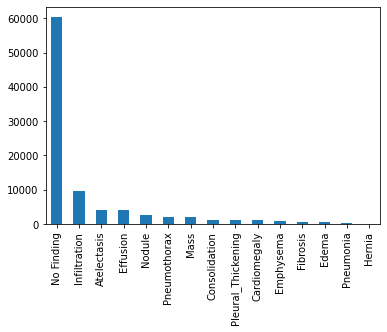

In [9]:
## Remove samples with multiple labels (hint: multiple labels are divided with |)
df = df[~df['Finding Labels'].str.contains('\|')]

df['Finding Labels'].value_counts()

df['Finding Labels'].value_counts().plot(kind='bar')

### Remove samples with `findings_v2` labels

In [10]:
FINDINGS_V1 = ['Atelectasis', 'Cardiomegaly', 'Effusion', 'Infiltration', 'Mass', 'Nodule', 'Pneumonia', 'Pneumothorax']
FINDINGS_V2 = ['Hernia', 'Emphysema', 'Pleural_Thickening', 'Fibrosis', 'Consolidation', 'Edema']
              # We will keep 'No Finding' class of the 'v2' dataset for this workshop

No Finding      60361
Infiltration     9547
Atelectasis      4215
Effusion         3955
Nodule           2705
Pneumothorax     2194
Mass             2139
Cardiomegaly     1093
Pneumonia         322
Name: Finding Labels, dtype: int64


/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4174: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


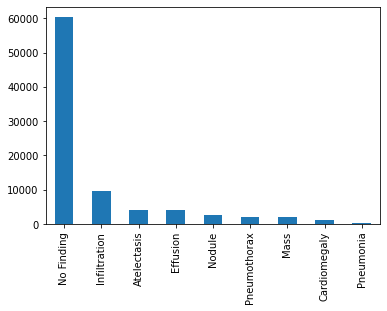

In [11]:
## Remove samples with `findings_v2` labels
df.drop(df[df['Finding Labels'].str.match('|'.join(FINDINGS_V2))].index, inplace=True)

print(df['Finding Labels'].value_counts())

df['Finding Labels'].value_counts().plot(kind='bar')

### Randomly drop 50.000 samples with `No Finding` label

No Finding      10361
Infiltration     9547
Atelectasis      4215
Effusion         3955
Nodule           2705
Pneumothorax     2194
Mass             2139
Cardiomegaly     1093
Pneumonia         322
Name: Finding Labels, dtype: int64


/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4174: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


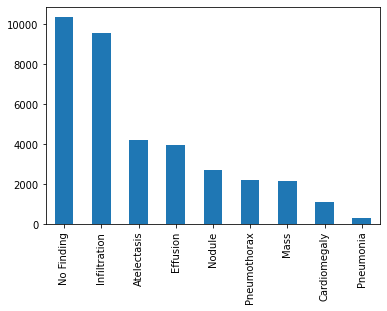

In [12]:
## Randomly drop 50.000 samples with `No Finding` label

df.drop(
    df[df['Finding Labels'].str.match('No Finding')].sample(n=50000, random_state=2021).index, 
    inplace=True
    )

print(df['Finding Labels'].value_counts())

df['Finding Labels'].value_counts().plot(kind='bar')

## Sync DF with images

In [13]:
def sync_files_csv():
    images = {f for f in os.listdir(IMAGES_DIR) if f.endswith('.png')}
    image_index = set(df['Image Index'])
    print('sync_files_csv - Before images: {} ; Before CSV: {}'.format(len(images), len(df)))
    
    diff = list(images.symmetric_difference(image_index))
    print('images - image_index: {}'.format(len(diff)))
    
    for image in tqdm.tqdm(diff):
        try:
            os.remove(os.path.join(IMAGES_DIR, image))
        except:
            pass
        df.drop(df[df['Image Index'].str.match(image)].index, inplace=True)
    
    images = {f for f in os.listdir(IMAGES_DIR) if f.endswith('.png')}
    print('sync_files_csv - After images: {} ; After CSV: {}'.format(len(images), len(df)))

if DOWNLOAD_IMAGES:
    sync_files_csv()

## Resize images

In [14]:
def resize(img_path):
    try:
        img = Image.open(img_path)
        img_resized = img.resize(IMAGE_NEW_RESOLUTION)
        img_resized.save(img_path, "PNG")
    except Exception as ex:
        print('Error when processing {}. Removing image. Exception: {}'.format(img_name, ex))
        os.remove(img_path)

In [15]:
if DOWNLOAD_IMAGES:
    images = [os.path.join(IMAGES_DIR, img_name) for img_name in os.listdir(IMAGES_DIR) if img_name.endswith('.png')]

    print('Resizing images to {}'.format(IMAGE_NEW_RESOLUTION))

    with Pool(cpu_count()) as p:
        r = list(
            tqdm.tqdm(
                p.imap(resize, images),
                total=len(images)
            )
        )

## Save results

In [16]:
if DOWNLOAD_IMAGES:
    archive = os.path.join(DATA_DIR, 'nih_chest_xray_single_9c_{}x{}.tar.gz'.format(IMAGE_NEW_RESOLUTION[0], IMAGE_NEW_RESOLUTION[1]))

    if not os.path.exists(archive):
        ! tar -czf $archive $IMAGES_DIR
    else:
        print('Archive {} already exists'.format(archive))
    
    df.reindex()
    df.to_csv(os.path.join(DATA_DIR, 'nih_chest_xray_single_9c.csv'))